In [1]:
import pandas as pd
import pyarrow.parquet as pq 
train = pq.read_table(source='C:/Users/tomas/OneDrive/Escritorio/ORGA DE DATOS/train').to_pandas()
test = pq.read_table(source='C:/Users/tomas/OneDrive/Escritorio/ORGA DE DATOS/test').to_pandas()

In [2]:
for column in train:
    if(column == "content"):
        train[column].fillna(value="",inplace=True)
    else:
        if(train[column].isnull().sum() != 0):
            media = train[column].mean()
            train[column].fillna(value=media, inplace=True)

In [3]:
for column in test:
    if(column == "content"):
        test[column].fillna(value="",inplace=True)
    else:
        if(test[column].isnull().sum() != 0):
            media = test[column].mean()
            test[column].fillna(value=media, inplace=True)

In [4]:
train = train.iloc[:(8*len(train)//10)]
valid = train.iloc[(8*len(train)//10):]

In [5]:
X_train = train.drop(['url','timedelta','popular','shares'],axis = 1)
y_train = train["popular"]*1

X_valid = valid.drop(['url','timedelta','popular','shares'],axis = 1)
y_valid = valid["popular"]*1

X_test = test.drop(['url','timedelta','popular','shares'],axis = 1)
y_test = test["popular"]*1

In [6]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from category_encoders import TargetEncoder

In [7]:
ohe_surprise1 = OneHotEncoder()
encoded_surp = ohe_surprise1.fit_transform(X_train[["surprise1"]]).toarray()
encoded_surp_test = ohe_surprise1.transform(X_test[["surprise1"]]).toarray()
encoded_surp_valid = ohe_surprise1.transform(X_valid[["surprise1"]]).toarray()

feature_labels = np.array(ohe_surprise1.categories_).ravel()
X_train = X_train.reset_index().drop(['index','surprise1'],axis = 1).join(pd.DataFrame(encoded_surp, columns = feature_labels))
X_test = X_test.reset_index().drop(['index','surprise1'],axis = 1).join(pd.DataFrame(encoded_surp_test, columns = feature_labels))
X_valid = X_valid.reset_index().drop(['index','surprise1'],axis = 1).join(pd.DataFrame(encoded_surp_valid, columns = feature_labels))

In [8]:
vect_content = CountVectorizer(analyzer = "word", stop_words = "english", max_features = 15)
encoded_content = vect_content.fit_transform(X_train["content"].tolist()).toarray()
encoded_content_test = vect_content.transform(X_test["content"].tolist()).toarray()
encoded_content_valid = vect_content.transform(X_valid["content"].tolist()).toarray()

In [9]:
X_train = X_train.reset_index().drop(['index','content'],axis = 1).join(pd.DataFrame(encoded_content, columns = vect_content.get_feature_names_out()))
X_test = X_test.reset_index().drop(['index','content'],axis = 1).join(pd.DataFrame(encoded_content_test, columns = vect_content.get_feature_names_out()))
X_valid = X_valid.reset_index().drop(['index','content'],axis = 1).join(pd.DataFrame(encoded_content_valid, columns = vect_content.get_feature_names_out()))

In [10]:
te = TargetEncoder()

C:\Users\tomas\AppData\Local\Programs\Python\Python37\lib\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\tomas\AppData\Local\Programs\Python\Python37\lib\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [11]:
encoded_surp2 = te.fit_transform(X_train["surprise2"],y_train)
encoded_surp2_test = te.transform(X_test["surprise2"],y_test)
encoded_surp2_valid = te.transform(X_valid["surprise2"],y_valid.reset_index().drop(["index"],axis = 1))

In [12]:
X_train = X_train.reset_index().drop(['index','surprise2'],axis = 1).join(pd.DataFrame(encoded_surp2, columns = te.get_feature_names()))
X_test = X_test.reset_index().drop(['index','surprise2'],axis = 1).join(pd.DataFrame(encoded_surp2_test, columns = te.get_feature_names()))
X_valid = X_valid.reset_index().drop(['index','surprise2'],axis = 1).join(pd.DataFrame(encoded_surp2_valid, columns = te.get_feature_names()))

In [13]:
from xgboost import XGBClassifier
model = XGBClassifier()
param_grid={"learning_rate": (0.05, 0.10, 0.15),
            "max_depth": [1,2,3,4,5,6,8,9,10,11],
            "min_child_weight": [ 1, 3, 5, 7],
            "gamma":[ 0.0, 0.1, 0.2],
            'n_estimators': [200, 400, 600, 800, 1000],
            "colsample_bytree":[ 0.3, 0.4]}

In [14]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 3, verbose = 2, n_jobs = -1, random_state = 42)

In [15]:
rf.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=Non

In [16]:
print(rf.best_score_)

0.7821591307395724


In [17]:
modeloPrueba = rf.best_estimator_
modeloPrueba.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [18]:
print(f'Accuracy - : {modeloPrueba.score(X_train,y_train):.3f}')

Accuracy - : 0.816


In [19]:
prediccion_binaria = modeloPrueba.predict(X_valid)
prediccion_binaria

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
proba_preds = modeloPrueba.predict_proba(X_valid)[:,1]
proba_preds

array([0.10454371, 0.0785302 , 0.04182702, ..., 0.1485986 , 0.06332923,
       0.2573698 ], dtype=float32)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, prediccion_binaria))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4586
           1       0.82      0.16      0.27      1120

    accuracy                           0.83      5706
   macro avg       0.82      0.58      0.59      5706
weighted avg       0.83      0.83      0.78      5706



In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid,proba_preds)

0.8210911703320665

In [24]:
nuevo_df = test
df_test = nuevo_df.reset_index().drop(['index'],axis = 1).join(pd.DataFrame(modeloPrueba.predict_proba(X_test),columns = ["False","True"]))

In [30]:
#CSV
df_test[["popular","False","True"]]

,popular,False,True
0,False,0.906611,0.093389
1,False,0.802092,0.197908
2,False,0.862150,0.137850
3,False,0.783849,0.216151
4,True,0.926071,0.073929
...,...,...,...
3976,False,0.644426,0.355574
3977,False,0.793329,0.206671
3978,False,0.725777,0.274223
3979,False,0.972185,0.027815


In [29]:
#FEATURE IMPORTANCE

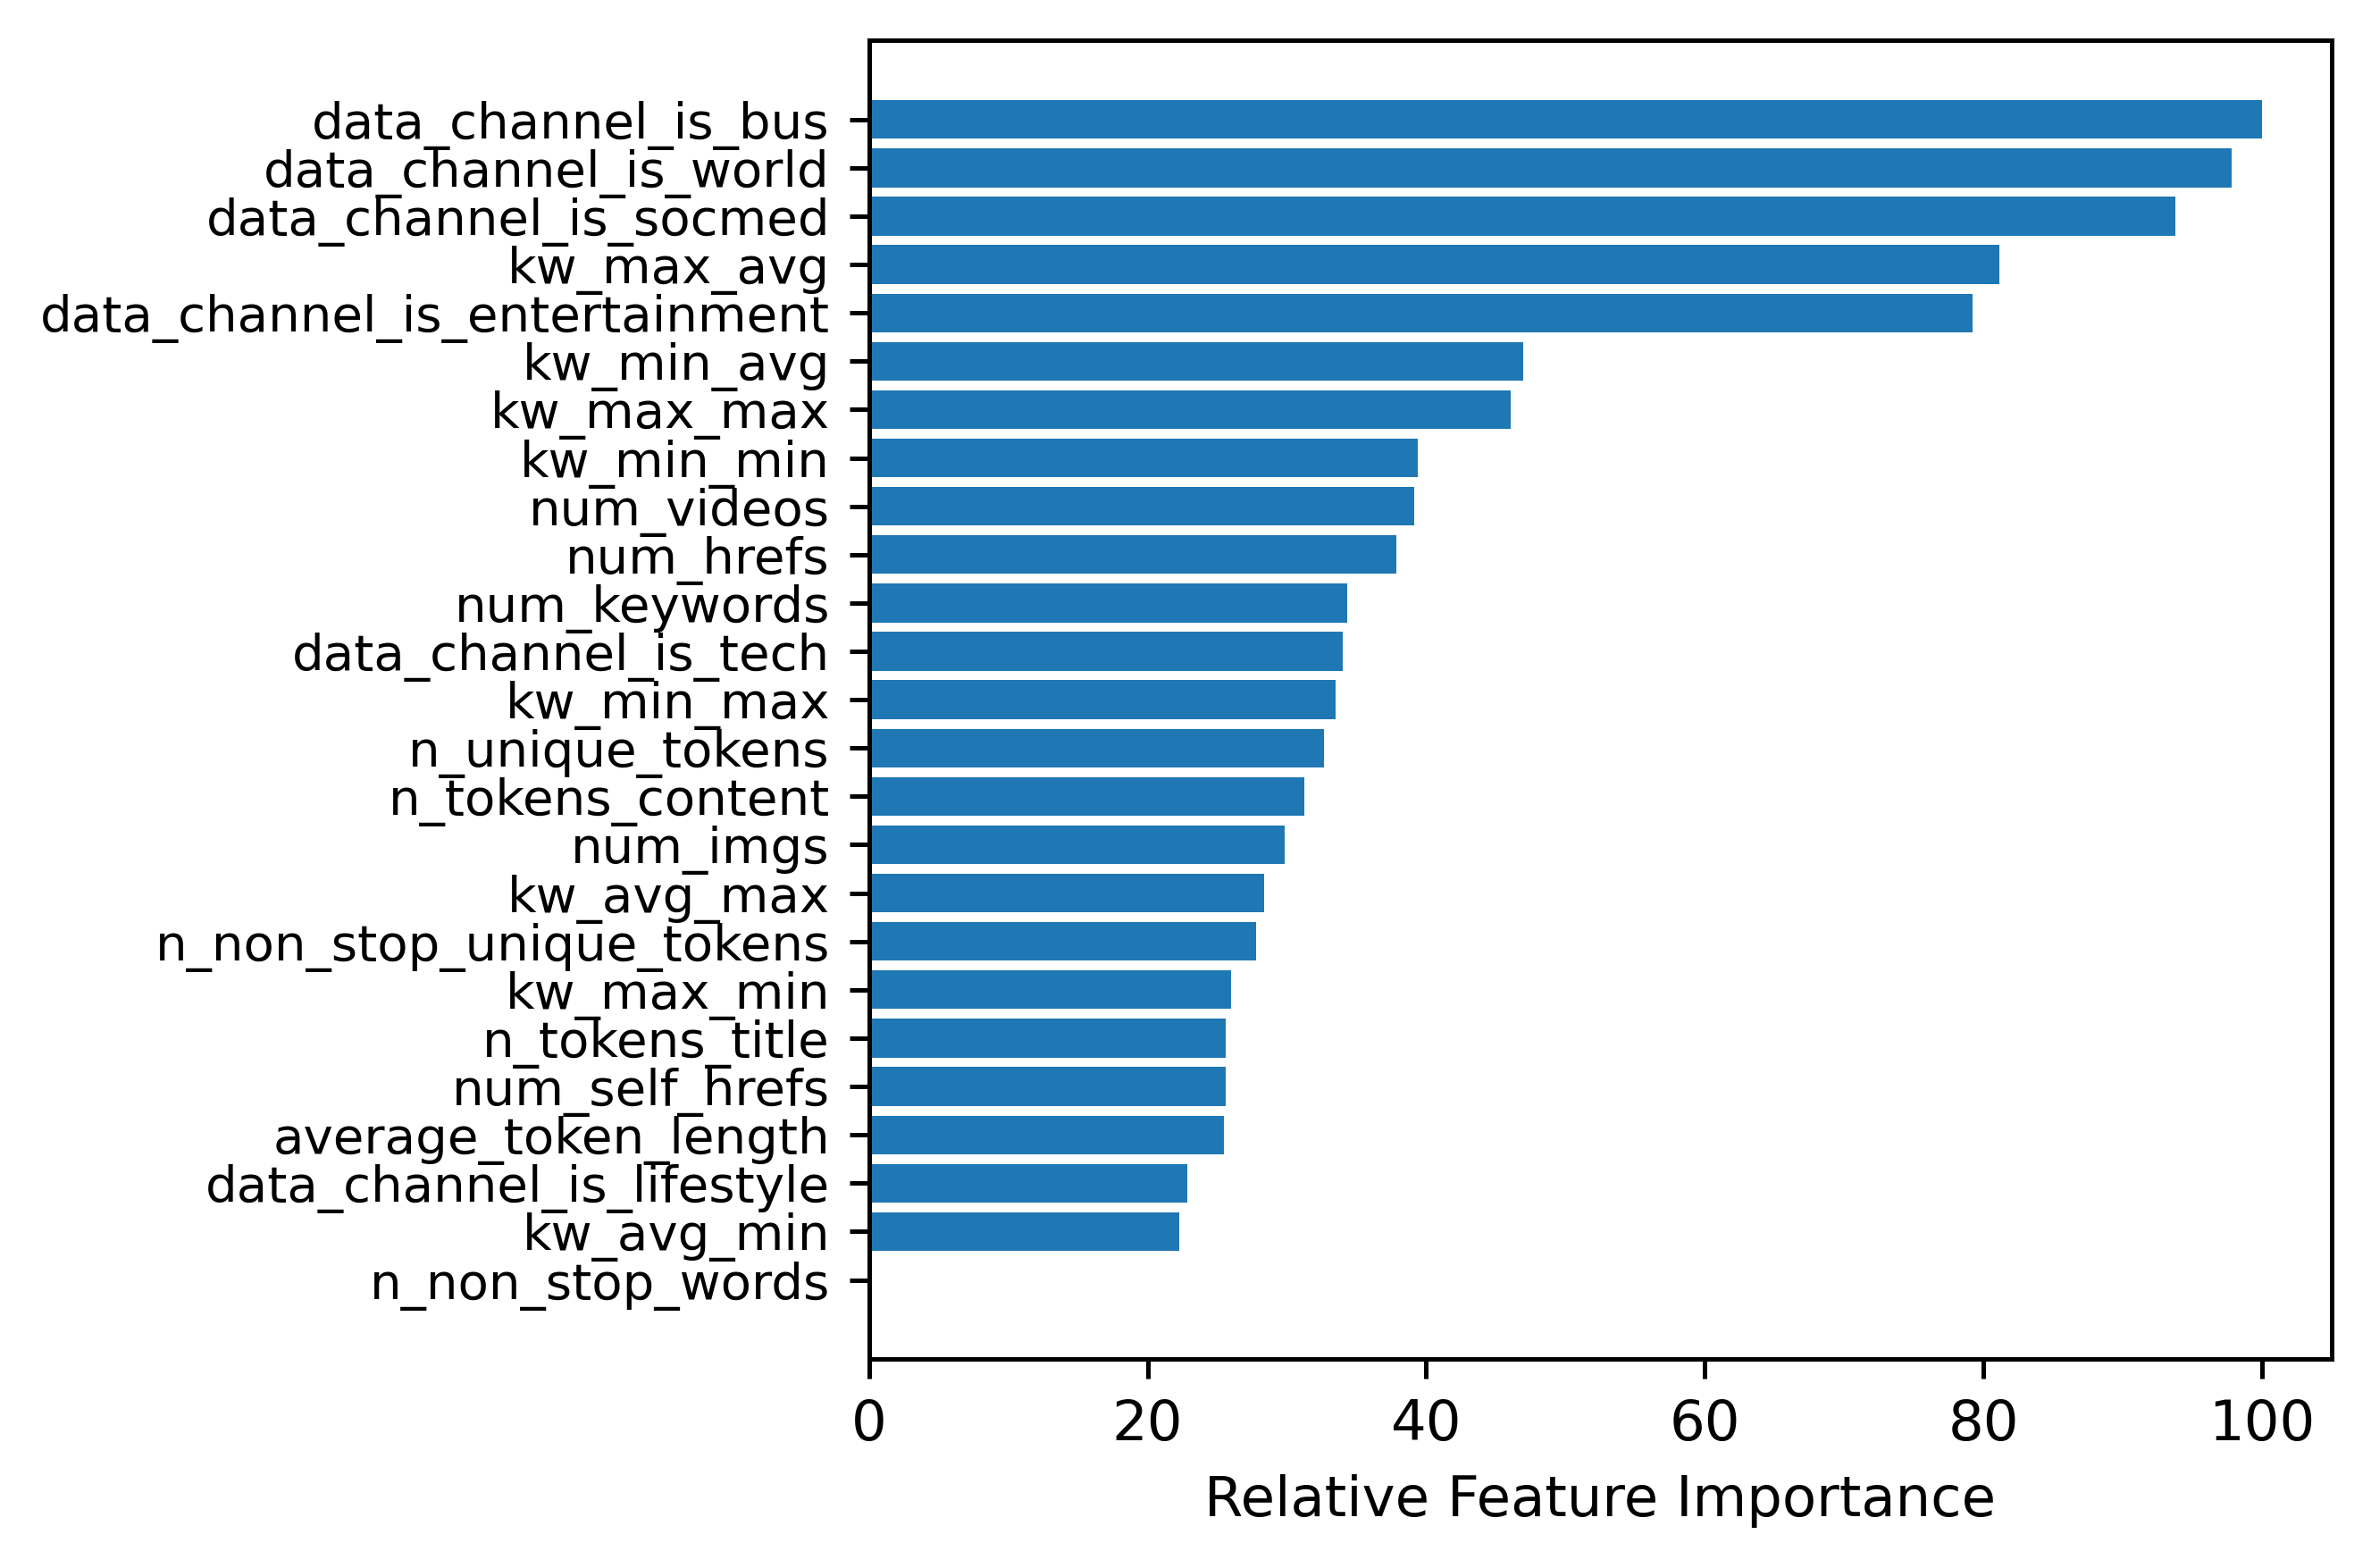

In [30]:
import matplotlib.pyplot as plt
feature_importance = abs(modeloPrueba.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance[0:25])
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(dpi = 450)
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(X_train.columns[sorted_idx], fontsize=9)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

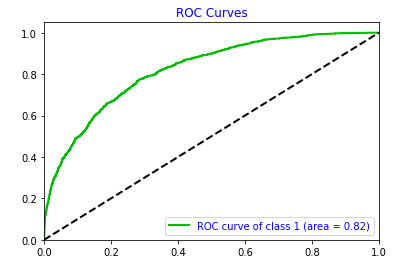

In [31]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_valid, modeloPrueba.predict_proba(X_valid), classes_to_plot=1,plot_micro=False,plot_macro=False, 
                      figsize = plt.rcParams.update({'text.color': 'blue', 'axes.labelcolor': 'white'}))

In [32]:
roc_auc_score(y_test,modeloPrueba.predict_proba(X_test)[:,1])

0.7212499729028962